# ARIMA Time Series Forecasting for Predicting Pollutant Concentration and Asthma ED Presentations based on Historical Levels

## Set Up

Import the required libraries and dataset, and format appropriately.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

df = pd.read_csv("../datasets/_integrated-data/processed-monthly-genderless.csv")
df = df.drop(['lhd'], axis=1)
df['year-month'] = pd.to_datetime(df['year-month'])
df = df.groupby('year-month').mean().reset_index()

# Count of number of pollutant features in the dataset
column_list = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']
n_pollutants = sum([1 for col in df.columns if col in column_list])

# Efeaturetract pollutant columns and columns after the pollutants
pollutant_columns = [col for col in df.columns if col in column_list]
health_stat_columns = df.iloc[:, df.columns.get_loc(pollutant_columns[-1]) + 1:]

# Show the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of pollutant features: {n_pollutants}")
df.describe()
print(df)


Dataset shape: (120, 8)
Number of pollutant features: 6
    year-month    CO ppm   NO pphm  NO2 pphm  OZONE pphm  PM10 µg/m³  \
0   2014-07-01  0.149718  0.881262  0.787044    1.638223   16.071168   
1   2014-08-01  0.148803  0.662244  0.721435    1.884988   16.421492   
2   2014-09-01  0.120137  0.466746  0.636459    2.057258   15.690663   
3   2014-10-01  0.146763  0.384355  0.558555    2.380655   19.603422   
4   2014-11-01  0.135941  0.332400  0.491272    2.459342   21.488789   
..         ...       ...       ...       ...         ...         ...   
115 2024-02-01  0.080457  0.447631  0.417366    1.761401   20.941416   
116 2024-03-01  0.097885  0.457284  0.474484    1.748646   20.502465   
117 2024-04-01  0.096486  0.528494  0.602781    1.620769   18.039018   
118 2024-05-01  0.119582  0.895901  0.756629    1.363354   16.438771   
119 2024-06-01  0.113310  0.865902  0.765549    1.422019   14.454383   

     SO2 pphm  asthma edp  
0    0.055315   33.284615  
1    0.049879   36.9230

## Exploratory Data Analysis

Plot the particle concentrations over time for each particle.

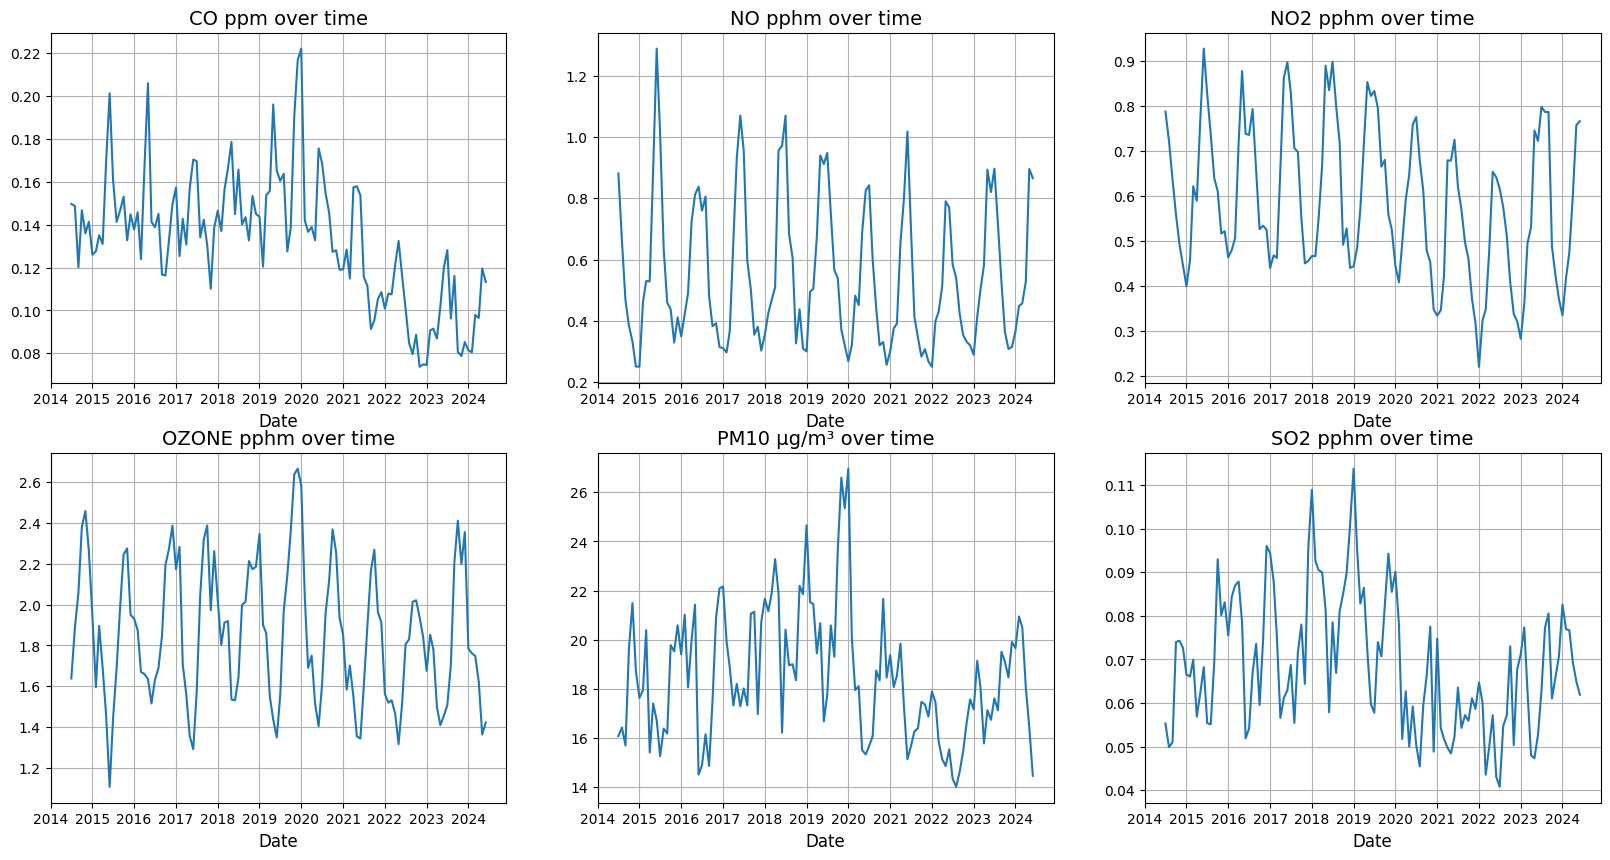

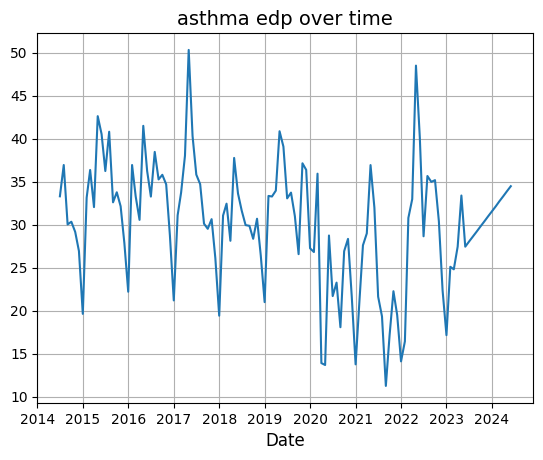

In [4]:
plt.figure(figsize=(20, 10))
i=1
for pol in pollutant_columns:
    plt.subplot(2,3,i)
    plt.plot(df['year-month'], df[pol], label=pol)
    plt.title(pol + ' over time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.grid(True)
    i = i + 1
plt.show()

plt.plot(df['year-month'], df['asthma edp'], label='asthma edp')
plt.title('asthma edp over time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()


## Model Training Preparation

Prepare the data for training the model.

### Predicting Pollutant Levels

ADF Statistic: -0.5308262718769068
p-value: 0.8858592894610009
year-month    datetime64[ns]
CO ppm               float64
NO pphm              float64
NO2 pphm             float64
OZONE pphm           float64
PM10 µg/m³           float64
SO2 pphm             float64
dtype: object


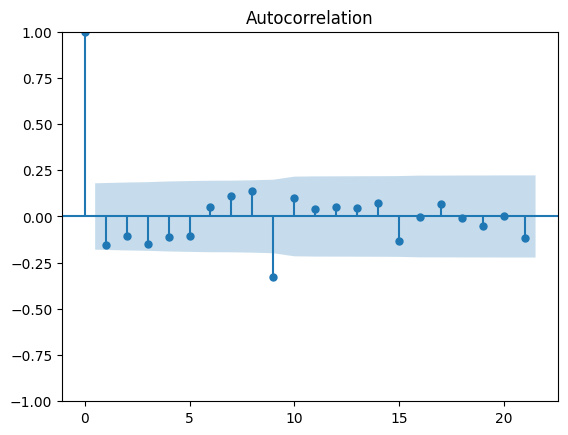

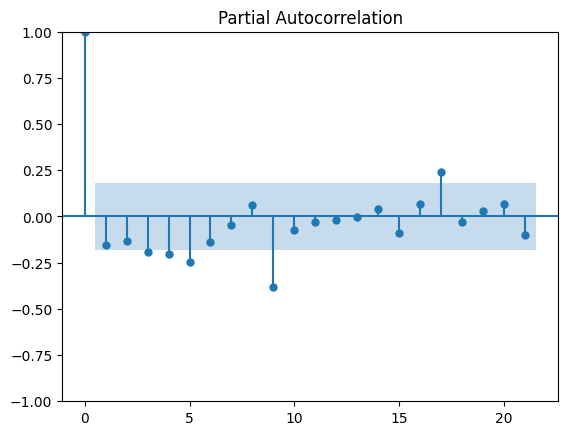

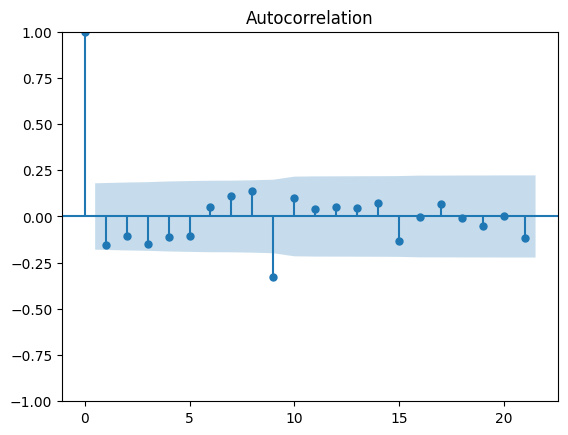

In [16]:
# Check for stationary
result = adfuller(df['CO ppm'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# difference data to make stationary
df_data_diff = df[pollutant_columns].diff().dropna()
df_data_diff.insert(0, "year-month", df['year-month'], True)

print(df_data_diff.dtypes)
# Determine ARIMA p and q value
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.graphics.tsaplots import plot_acf 
plot_pacf(df_data_diff['CO ppm'])
plot_acf(df_data_diff['CO ppm'])

- P was chosen at 17 as it is the next most significant lag out of the limit.
- Q was chosen as 8 for the same reason.

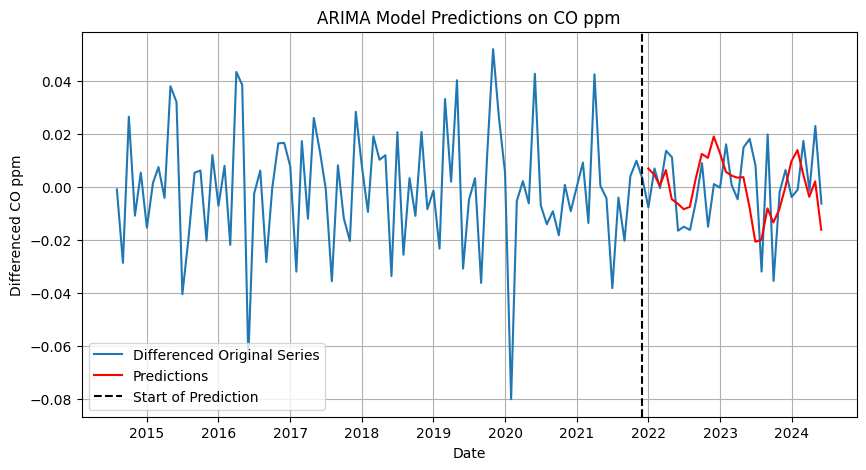

MAE: 0.13
MSE: 0.02
RMSE: 0.13


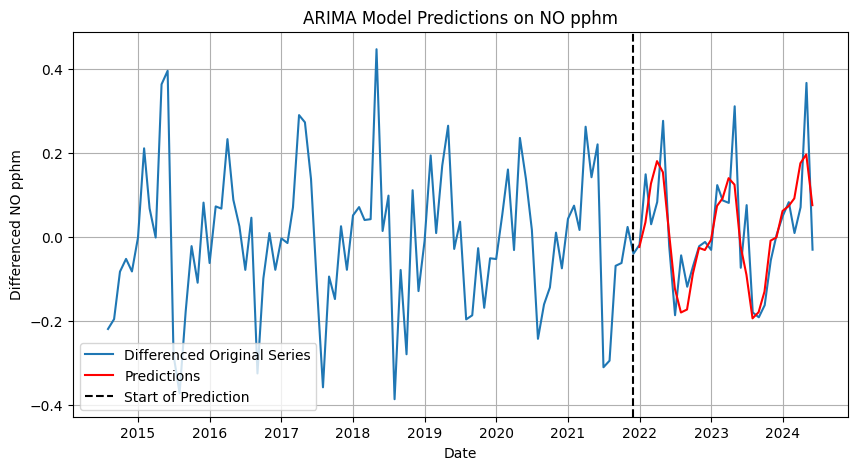

MAE: 0.33
MSE: 0.16
RMSE: 0.40


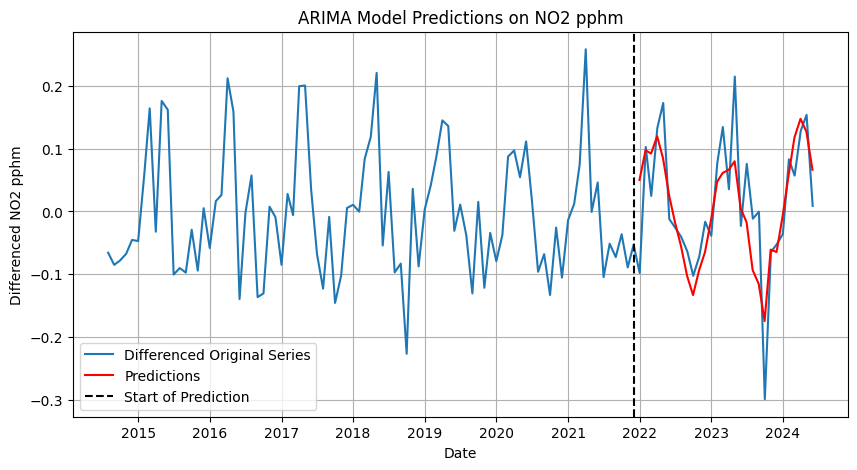

MAE: 0.47
MSE: 0.26
RMSE: 0.51


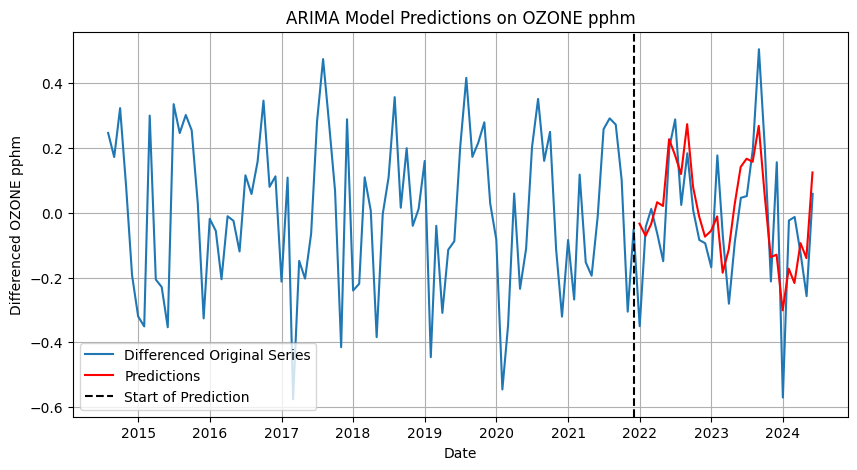

MAE: 2.43
MSE: 6.04
RMSE: 2.46


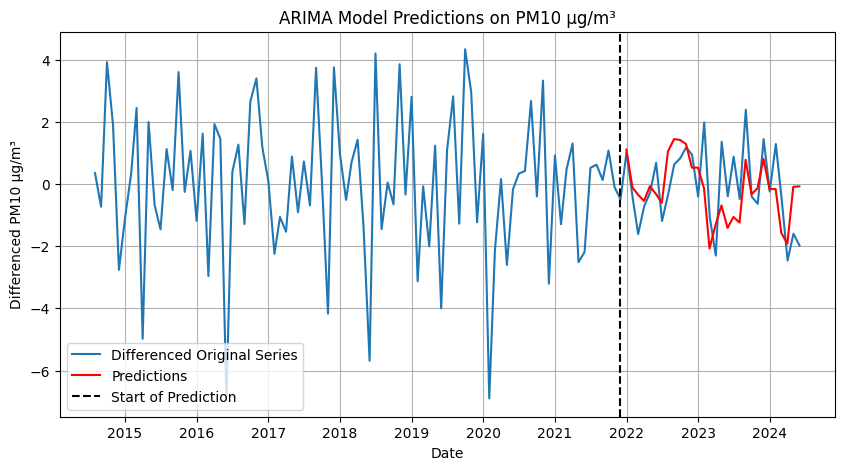

MAE: 17.33
MSE: 307.50
RMSE: 17.54


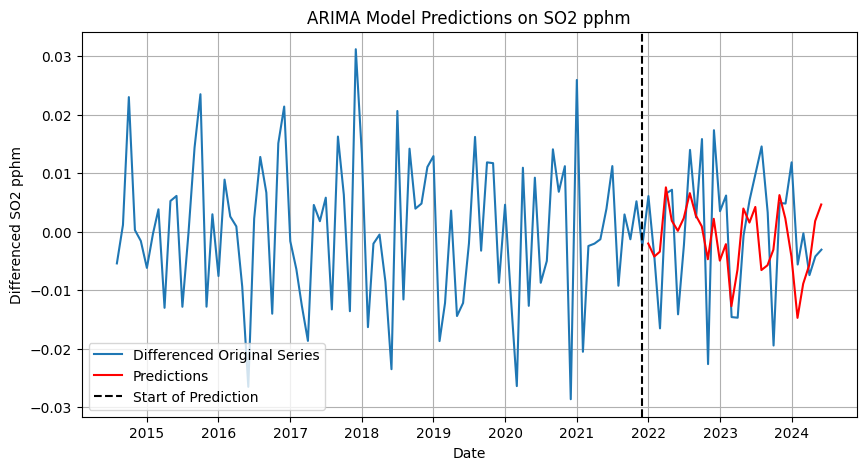

MAE: 0.05
MSE: 0.00
RMSE: 0.05


In [20]:
i=1

for pol in pollutant_columns:
    
    train_size = int(len(df_data_diff) * 0.75)
    train, test = df_data_diff[pol][:train_size], df_data_diff[pol][train_size:]

    # Fit the ARMA(17, 8) model
    model = ARIMA(df_data_diff[pol], order=(8, 0, 8))
    model_fit = model.fit()

    # Calculate the starting point: quarter of the way from the end
    start = train_size  # Start 1/4 from the end
    end = train_size + len(test) - 1 # Predicting until the end of timeline.

    predictions = model_fit.predict(start=start, end=end)

    predictions_actual_scale = predictions.cumsum() + df[pol].iloc[start - 1]

    mae = mean_absolute_error(test, predictions_actual_scale)
    mse = mean_squared_error(test, predictions_actual_scale)
    rmse = np.sqrt(mse)

    # Generate future dates for the prediction plot
    last_date = df['year-month'].iloc[start]
    future_dates = pd.date_range(start=last_date, periods=(end - start + 1), freq='M')

    # Create DataFrame for predictions with future dates
    predictions_df = pd.DataFrame({
        'year-month': future_dates,
        'Predicted {pol}': predictions
    })

    # Plot the differenced original series and the predictions
    plt.figure(figsize=(10, 5))
    plt.plot(df_data_diff['year-month'], df_data_diff[pol], label='Differenced Original Series')
    plt.plot(predictions_df['year-month'], predictions_df['Predicted {pol}'], label='Predictions', color='red')
    plt.axvline(x=last_date, color='black', linestyle='--', label='Start of Prediction')
    plt.legend(loc='lower left')
    plt.title('ARIMA Model Predictions on '+pol)
    plt.xlabel('Date')
    plt.ylabel('Differenced '+pol)
    plt.grid(True)
    plt.show()
    print(f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}')
    i = i + 1

### Predicting Asthma Emergency Department Presentations

ADF Statistic: -2.0751389856940814
p-value: 0.2546281117779826
0      33.284615
1      36.923077
2      30.015385
3      30.330769
4      29.146154
         ...    
115    32.117160
116    32.702959
117    33.288757
118    33.874556
119    34.460355
Name: asthma edp, Length: 120, dtype: float64
    year-month  asthma edp
1   2014-08-01    3.638462
2   2014-09-01   -6.907692
3   2014-10-01    0.315385
4   2014-11-01   -1.184615
5   2014-12-01   -2.223077
..         ...         ...
115 2024-02-01    0.585799
116 2024-03-01    0.585799
117 2024-04-01    0.585799
118 2024-05-01    0.585799
119 2024-06-01    0.585799

[119 rows x 2 columns]


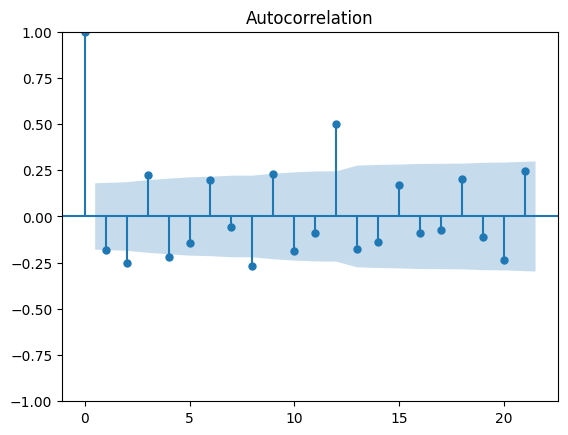

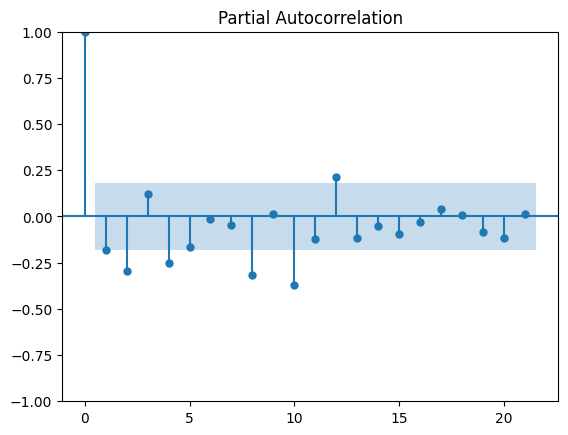

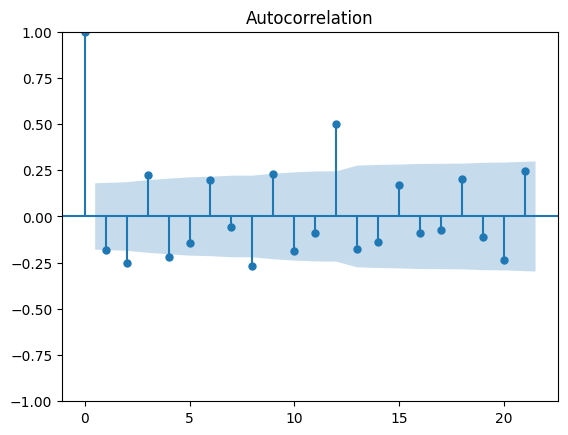

In [14]:
# Check for stationary
result = adfuller(df['asthma edp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

print(df['asthma edp'])

# difference data to make stationary
edp_diff = df['asthma edp'].diff().dropna()

df_data_diff = pd.DataFrame({
    'year-month': df['year-month'].iloc[1:],
    'asthma edp': edp_diff
})

print (df_data_diff)

# Determine ARIMA p and q value
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.graphics.tsaplots import plot_acf 
plot_pacf(df_data_diff['asthma edp'])
plot_acf(df_data_diff['asthma edp'])

- P was chosen at 10 as it is the next most significant lag out of the limit.
- Q was chosen as 13 for the same reason.

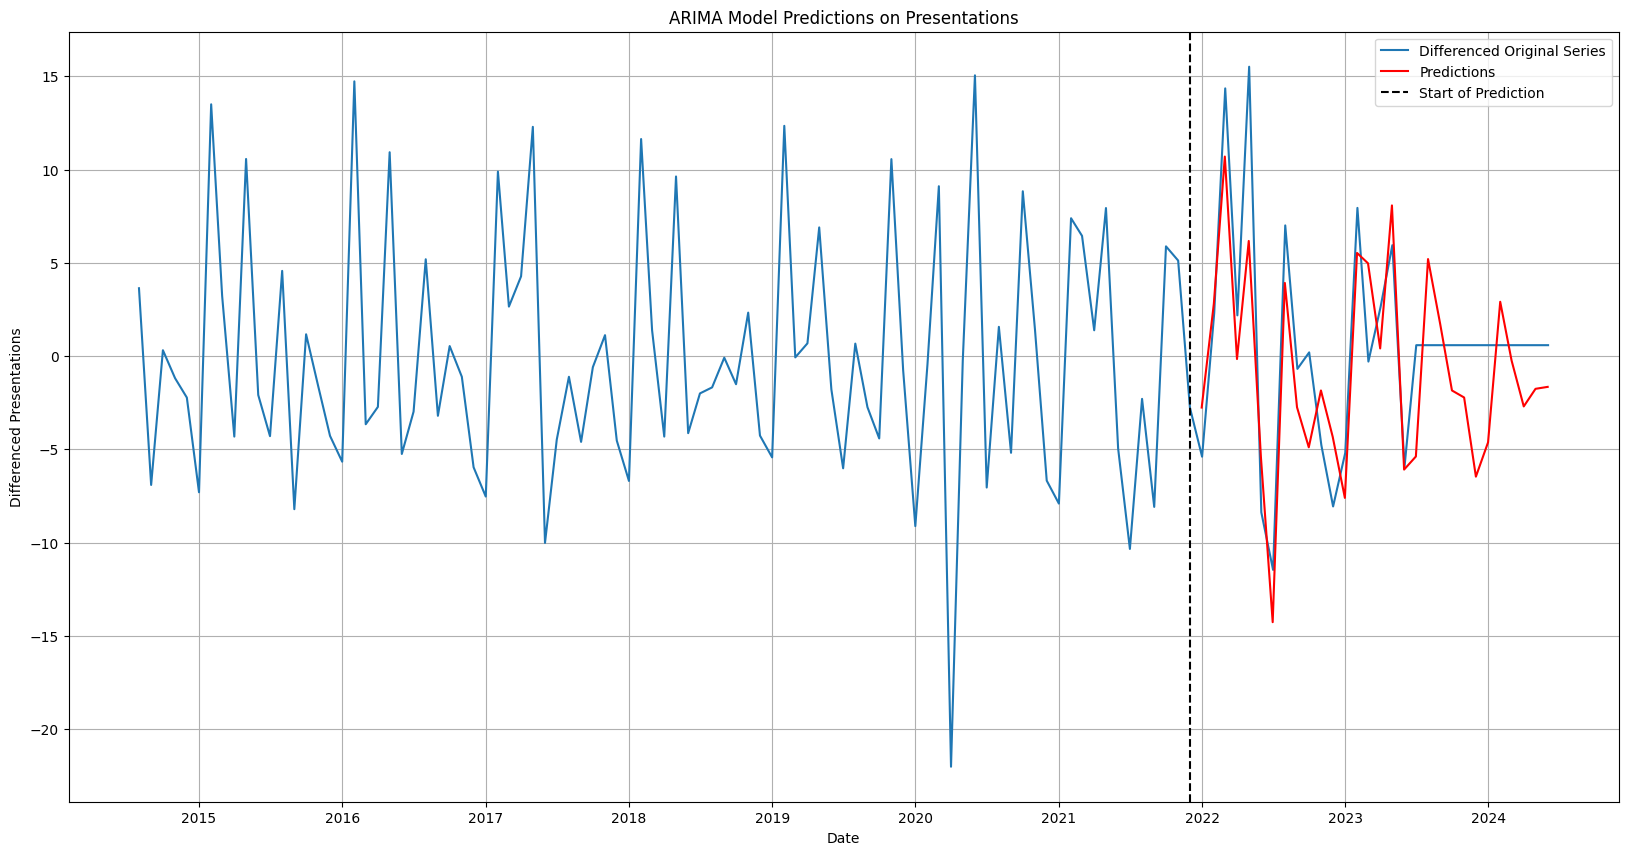

MAE: 3.20
MSE: 13.91
RMSE: 3.73


In [15]:
plt.figure(figsize=(20, 10))

train_size = int(len(df_data_diff) * 0.75)
train, test = df_data_diff['asthma edp'][:train_size], df_data_diff['asthma edp'][train_size:]

# Fit the ARMA(1, 1) model
model = ARIMA(df_data_diff['asthma edp'], order=(10, 0, 13))
model_fit = model.fit()

# Calculate the starting point: quarter of the way from the end
start = train_size  # Start 1/4 from the end
end = train_size + len(test) - 1 # Predicting 20 steps from this starting point

predictions = model_fit.predict(start=start, end=end)

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

# Generate future dates for the prediction plot
last_date = df['year-month'].iloc[start]
future_dates = pd.date_range(start=last_date, periods=(end - start + 1), freq='M')

# Create DataFrame for predictions with future dates
predictions_df = pd.DataFrame({
    'year-month': future_dates,
    'Predicted Presentations': predictions
})

# Plot the differenced original series and the predictions
plt.plot(df_data_diff['year-month'], df_data_diff['asthma edp'], label='Differenced Original Series')
plt.plot(predictions_df['year-month'], predictions_df['Predicted Presentations'], label='Predictions', color='red')
plt.axvline(x=last_date, color='black', linestyle='--', label='Start of Prediction')
plt.legend(loc='lower left')
plt.title('ARIMA Model Predictions on Presentations')
plt.xlabel('Date')
plt.ylabel('Differenced Presentations')
plt.grid(True)
plt.show()

# Print evaluation results
print(f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}')